## Resources
- Huang, H., Lin, L., Tong, R., Hu, H., Zhang, Q., Iwamoto, Y., Han, X., Chen, Y.W. and Wu, J., 2020. UNet 3+: A Full-Scale Connected UNet for Medical Image Segmentation. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1055-1059). IEEE.
- [keras-unet-collection](https://github.com/yingkaisha/keras-unet-collection)
- [Volume Segmentation using UNet](https://github.com/madsendennis/notebooks/tree/master/volume_segmentation_with_unet)
- [Dataset Left Ventricular Myocardial Infarction Segmentation](https://www.cardiacatlas.org/challenges/ventricular-infarct-segmentation/)
- [ACDC Databases](https://acdc.creatis.insa-lyon.fr/description/databases.html)
- [Deep Learning Calcium Score](https://www.nature.com/articles/s41746-021-00460-1#data-availability)
- [COCA Dataset](https://stanfordaimi.azurewebsites.net/datasets/e8ca74dc-8dd4-4340-815a-60b41f6cb2aa)
- [Calcium Scoring Method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5487233/)
- [UNet Architecture (For Reference)](https://medium.com/projectpro/u-net-convolutional-networks-for-biomedical-image-segmentation-435699255d26)

### Import

In [33]:
import os
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import xml.etree.ElementTree as ET

### Data Exploration

(512, 512)


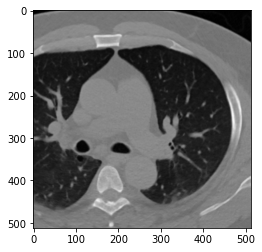

In [43]:
n="02"
ds = dcmread(r"C:\Users\adity\OneDrive - Institut Teknologi Sepuluh Nopember\TA\cocacoronarycalciumandchestcts-2\Gated_release_final\patient\0\Pro_Gated_CS_3.0_I30f_3_70%\IM-6130-00"+n+".dcm")
arr = ds.pixel_array
print(arr.shape)
plt.imshow(arr, cmap="gray")

In [42]:
tree = ET.parse(r'C:\Users\adity\OneDrive - Institut Teknologi Sepuluh Nopember\TA\cocacoronarycalciumandchestcts-2\Gated_release_final\calcium_xml\0.xml')
root = tree.getroot()
for neighbor in root.iter('Images'):
    print(neighbor.tag, neighbor.attrib)

## Activation

In [6]:

from tensorflow import math
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K


def gelu_(X):

    return 0.5*X*(1.0 + math.tanh(0.7978845608028654*(X + 0.044715*math.pow(X, 3))))

def snake_(X, beta):

    return X + (1/beta)*math.square(math.sin(beta*X))


class GELU(Layer):
    '''
    Gaussian Error Linear Unit (GELU), an alternative of ReLU
    
    Y = GELU()(X)
    
    ----------
    Hendrycks, D. and Gimpel, K., 2016. Gaussian error linear units (gelus). arXiv preprint arXiv:1606.08415.
    
    Usage: use it as a tf.keras.Layer
    
    
    '''
    def __init__(self, trainable=False, **kwargs):
        super(GELU, self).__init__(**kwargs)
        self.supports_masking = True
        self.trainable = trainable

    def build(self, input_shape):
        super(GELU, self).build(input_shape)

    def call(self, inputs, mask=None):
        return gelu_(inputs)

    def get_config(self):
        config = {'trainable': self.trainable}
        base_config = super(GELU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    def compute_output_shape(self, input_shape):
        return input_shape

    
class Snake(Layer):
    '''
    Snake activation function $X + (1/b)*sin^2(b*X)$. Proposed to learn periodic targets.
    
    Y = Snake(beta=0.5, trainable=False)(X)
    
    ----------
    Ziyin, L., Hartwig, T. and Ueda, M., 2020. Neural networks fail to learn periodic functions 
    and how to fix it. arXiv preprint arXiv:2006.08195.
    
    '''
    def __init__(self, beta=0.5, trainable=False, **kwargs):
        super(Snake, self).__init__(**kwargs)
        self.supports_masking = True
        self.beta = beta
        self.trainable = trainable

    def build(self, input_shape):
        self.beta_factor = K.variable(self.beta, dtype=K.floatx(), name='beta_factor')
        if self.trainable:
            self._trainable_weights.append(self.beta_factor)

        super(Snake, self).build(input_shape)

    def call(self, inputs, mask=None):
        return snake_(inputs, self.beta_factor)

    def get_config(self):
        config = {'beta': self.get_weights()[0] if self.trainable else self.beta, 'trainable': self.trainable}
        base_config = super(Snake, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
    

## Layer Utils

In [7]:
from tensorflow import expand_dims
from tensorflow.compat.v1 import image
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax

def decode_layer(X, channel, pool_size, unpool, kernel_size=3, 
                 activation='ReLU', batch_norm=False, name='decode'):
    '''
    An overall decode layer, based on either upsampling or trans conv.
    
    decode_layer(X, channel, pool_size, unpool, kernel_size=3,
                 activation='ReLU', batch_norm=False, name='decode')
    
    Input
    ----------
        X: input tensor.
        pool_size: the decoding factor.
        channel: (for trans conv only) number of convolution filters.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.           
        kernel_size: size of convolution kernels. 
                     If kernel_size='auto', then it equals to the `pool_size`.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
    
    * The defaut: `kernel_size=3`, is suitable for `pool_size=2`.
    
    '''
    # parsers
    if unpool is False:
        # trans conv configurations
        bias_flag = not batch_norm
    
    elif unpool == 'nearest':
        # upsample2d configurations
        unpool = True
        interp = 'nearest'
    
    elif (unpool is True) or (unpool == 'bilinear'):
        # upsample2d configurations
        unpool = True
        interp = 'bilinear'
    
    else:
        raise ValueError('Invalid unpool keyword')
        
    if unpool:
        X = UpSampling2D(size=(pool_size, pool_size), interpolation=interp, name='{}_unpool'.format(name))(X)
    else:
        if kernel_size == 'auto':
            kernel_size = pool_size
            
        X = Conv2DTranspose(channel, kernel_size, strides=(pool_size, pool_size), 
                            padding='same', name='{}_trans_conv'.format(name))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_bn'.format(name))(X)
            
        # activation
        if activation is not None:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
        
    return X

def encode_layer(X, channel, pool_size, pool, kernel_size='auto', 
                 activation='ReLU', batch_norm=False, name='encode'):
    '''
    An overall encode layer, based on one of the:
    (1) max-pooling, (2) average-pooling, (3) strided conv2d.
    
    encode_layer(X, channel, pool_size, pool, kernel_size='auto', 
                 activation='ReLU', batch_norm=False, name='encode')
    
    Input
    ----------
        X: input tensor.
        pool_size: the encoding factor.
        channel: (for strided conv only) number of convolution filters.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        kernel_size: size of convolution kernels. 
                     If kernel_size='auto', then it equals to the `pool_size`.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    # parsers
    if (pool in [False, True, 'max', 'ave']) is not True:
        raise ValueError('Invalid pool keyword')
        
    # maxpooling2d as default
    if pool is True:
        pool = 'max'
        
    elif pool is False:
        # stride conv configurations
        bias_flag = not batch_norm
    
    if pool == 'max':
        X = MaxPooling2D(pool_size=(pool_size, pool_size), name='{}_maxpool'.format(name))(X)
        
    elif pool == 'ave':
        X = AveragePooling2D(pool_size=(pool_size, pool_size), name='{}_avepool'.format(name))(X)
        
    else:
        if kernel_size == 'auto':
            kernel_size = pool_size
        
        # linear convolution with strides
        X = Conv2D(channel, kernel_size, strides=(pool_size, pool_size), 
                   padding='valid', use_bias=bias_flag, name='{}_stride_conv'.format(name))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_bn'.format(name))(X)
            
        # activation
        if activation is not None:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
            
    return X

def attention_gate(X, g, channel,  
                   activation='ReLU', 
                   attention='add', name='att'):
    '''
    Self-attention gate modified from Oktay et al. 2018.
    
    attention_gate(X, g, channel,  activation='ReLU', attention='add', name='att')
    
    Input
    ----------
        X: input tensor, i.e., key and value.
        g: gated tensor, i.e., query.
        channel: number of intermediate channel.
                 Oktay et al. (2018) did not specify (denoted as F_int).
                 intermediate channel is expected to be smaller than the input channel.
        activation: a nonlinear attnetion activation.
                    The `sigma_1` in Oktay et al. 2018. Default is 'ReLU'.
        attention: 'add' for additive attention; 'multiply' for multiplicative attention.
                   Oktay et al. 2018 applied additive attention.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X_att: output tensor.
    
    '''
    activation_func = eval(activation)
    attention_func = eval(attention)
    
    # mapping the input tensor to the intermediate channel
    theta_att = Conv2D(channel, 1, use_bias=True, name='{}_theta_x'.format(name))(X)
    
    # mapping the gate tensor
    phi_g = Conv2D(channel, 1, use_bias=True, name='{}_phi_g'.format(name))(g)
    
    # ----- attention learning ----- #
    query = attention_func([theta_att, phi_g], name='{}_add'.format(name))
    
    # nonlinear activation
    f = activation_func(name='{}_activation'.format(name))(query)
    
    # linear transformation
    psi_f = Conv2D(1, 1, use_bias=True, name='{}_psi_f'.format(name))(f)
    # ------------------------------ #
    
    # sigmoid activation as attention coefficients
    coef_att = Activation('sigmoid', name='{}_sigmoid'.format(name))(psi_f)
    
    # multiplicative attention masking
    X_att = multiply([X, coef_att], name='{}_masking'.format(name))
    
    return X_att

def CONV_stack(X, channel, kernel_size=3, stack_num=2, 
               dilation_rate=1, activation='ReLU', 
               batch_norm=False, name='conv_stack'):
    '''
    Stacked convolutional layers:
    (Convolutional layer --> batch normalization --> Activation)*stack_num
    
    CONV_stack(X, channel, kernel_size=3, stack_num=2, dilation_rate=1, activation='ReLU', 
               batch_norm=False, name='conv_stack')
    
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of stacked Conv2D-BN-Activation layers.
        dilation_rate: optional dilated convolution kernel.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor
        
    '''
    
    bias_flag = not batch_norm
    
    # stacking Convolutional layers
    for i in range(stack_num):
        
        activation_func = eval(activation)
        
        # linear convolution
        X = Conv2D(channel, kernel_size, padding='same', use_bias=bias_flag, 
                   dilation_rate=dilation_rate, name='{}_{}'.format(name, i))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_{}_bn'.format(name, i))(X)
        
        # activation
        activation_func = eval(activation)
        X = activation_func(name='{}_{}_activation'.format(name, i))(X)
        
    return X

def Res_CONV_stack(X, X_skip, channel, res_num, activation='ReLU', batch_norm=False, name='res_conv'):
    '''
    Stacked convolutional layers with residual path.
     
    Res_CONV_stack(X, X_skip, channel, res_num, activation='ReLU', batch_norm=False, name='res_conv')
     
    Input
    ----------
        X: input tensor.
        X_skip: the tensor that does go into the residual path 
                can be a copy of X (e.g., the identity block of ResNet).
        channel: number of convolution filters.
        res_num: number of convolutional layers within the residual path.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''  
    X = CONV_stack(X, channel, kernel_size=3, stack_num=res_num, dilation_rate=1, 
                   activation=activation, batch_norm=batch_norm, name=name)

    X = add([X_skip, X], name='{}_add'.format(name))
    
    activation_func = eval(activation)
    X = activation_func(name='{}_add_activation'.format(name))(X)
    
    return X

def Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, dilation_rate=1, activation='ReLU', batch_norm=False, name='sep_conv'):
    '''
    Depthwise separable convolution with (optional) dilated convolution kernel and batch normalization.
    
    Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, dilation_rate=1, activation='ReLU', batch_norm=False, name='sep_conv')
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of stacked depthwise-pointwise layers.
        dilation_rate: optional dilated convolution kernel.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
    
    '''
    
    activation_func = eval(activation)
    bias_flag = not batch_norm
    
    for i in range(stack_num):
        X = DepthwiseConv2D(kernel_size, dilation_rate=dilation_rate, padding='same', 
                            use_bias=bias_flag, name='{}_{}_depthwise'.format(name, i))(X)
        
        if batch_norm:
            X = BatchNormalization(name='{}_{}_depthwise_BN'.format(name, i))(X)

        X = activation_func(name='{}_{}_depthwise_activation'.format(name, i))(X)

        X = Conv2D(channel, (1, 1), padding='same', use_bias=bias_flag, name='{}_{}_pointwise'.format(name, i))(X)
        
        if batch_norm:
            X = BatchNormalization(name='{}_{}_pointwise_BN'.format(name, i))(X)

        X = activation_func(name='{}_{}_pointwise_activation'.format(name, i))(X)
    
    return X

def ASPP_conv(X, channel, activation='ReLU', batch_norm=True, name='aspp'):
    '''
    Atrous Spatial Pyramid Pooling (ASPP).
    
    ASPP_conv(X, channel, activation='ReLU', batch_norm=True, name='aspp')
    
    ----------
    Wang, Y., Liang, B., Ding, M. and Li, J., 2019. Dense semantic labeling 
    with atrous spatial pyramid pooling and decoder for high-resolution remote 
    sensing imagery. Remote Sensing, 11(1), p.20.
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    * dilation rates are fixed to `[6, 9, 12]`.
    '''
    
    activation_func = eval(activation)
    bias_flag = not batch_norm

    shape_before = X.get_shape().as_list()
    b4 = GlobalAveragePooling2D(name='{}_avepool_b4'.format(name))(X)
    
    b4 = expand_dims(expand_dims(b4, 1), 1, name='{}_expdim_b4'.format(name))
    
    b4 = Conv2D(channel, 1, padding='same', use_bias=bias_flag, name='{}_conv_b4'.format(name))(b4)
    
    if batch_norm:
        b4 = BatchNormalization(name='{}_conv_b4_BN'.format(name))(b4)
        
    b4 = activation_func(name='{}_conv_b4_activation'.format(name))(b4)
    
    # <----- tensorflow v1 resize.
    b4 = Lambda(lambda X: image.resize(X, shape_before[1:3], method='bilinear', align_corners=True), 
                name='{}_resize_b4'.format(name))(b4)
    
    b0 = Conv2D(channel, (1, 1), padding='same', use_bias=bias_flag, name='{}_conv_b0'.format(name))(X)

    if batch_norm:
        b0 = BatchNormalization(name='{}_conv_b0_BN'.format(name))(b0)
        
    b0 = activation_func(name='{}_conv_b0_activation'.format(name))(b0)
    
    # dilation rates are fixed to `[6, 9, 12]`.
    b_r6 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=6, batch_norm=True, name='{}_sepconv_r6'.format(name))
    b_r9 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=9, batch_norm=True, name='{}_sepconv_r9'.format(name))
    b_r12 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=12, batch_norm=True, name='{}_sepconv_r12'.format(name))
    
    return concatenate([b4, b0, b_r6, b_r9, b_r12])

def CONV_output(X, n_labels, kernel_size=1, activation='Softmax', name='conv_output'):
    '''
    Convolutional layer with output activation.
    
    CONV_output(X, n_labels, kernel_size=1, activation='Softmax', name='conv_output')
    
    Input
    ----------
        X: input tensor.
        n_labels: number of classification label(s).
        kernel_size: size of 2-d convolution kernels. Default is 1-by-1.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                    Default option is 'Softmax'.
                    if None is received, then linear activation is applied.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    
    X = Conv2D(n_labels, kernel_size, padding='same', use_bias=True, name=name)(X)
    
    if activation:
        
        if activation == 'Sigmoid':
            X = Activation('sigmoid', name='{}_activation'.format(name))(X)
            
        else:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
            
    return X



In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model